## Définition des variables et modèles 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model, preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.feature_selection import SelectKBest, RFE, RFECV, chi2, f_regression
import time

Chargement du dataset pré-traité

In [3]:
df = pd.read_csv('df_for_model.csv')
df = df.drop('Unnamed: 0',axis=1)

Suppression des individus 'Hospital' qui agissent comme outliers

In [4]:
df=df.drop(df[df['PrimaryPropertyType']=='Hospital'].index)

Encodage des variables catégorielles 'Neighborhood' et 'PrimaryPropertyType'

In [5]:
data=df['Neighborhood'].values.reshape(-1,1)
enc = preprocessing.OneHotEncoder()
neighborhood_enc = enc.fit_transform(data).toarray()
neighborhood_enc.shape

(1800, 13)

In [6]:
data=df['PrimaryPropertyType'].values.reshape(-1,1)
enc = preprocessing.OneHotEncoder()
PropertyType_enc = enc.fit_transform(data).toarray()
PropertyType_enc.shape

(1800, 24)

In [7]:
# Concatenation des 2 encodages
X_cat = np.concatenate((neighborhood_enc,PropertyType_enc),axis=1)
X_cat.shape

(1800, 37)

Sélection des features encodées (utilisées uniquement pour certains prétraitements)

In [8]:
# X_cat = np.concatenate((neighborhood_enc,df[['Laboratory', 'Wholesale Club/Supercenter', 'Residential Care Facility',
#        'Refrigerated Warehouse', 'Other/Specialty Hospital',
#        'Other - Technology/Science', 'Other - Mall', 'Convention Center',
#        'Strip Mall', 'Vocational School', 'Police Station', 'Hotel',
#        'Food Service', 'SPS-District K-12', 'Supermarket/Grocery Store',
#        'Data Center', 'Urgent Care/Clinic/Other Outpatient', 'Library',
#        'Automobile Dealership', 'Senior Care Community',
#        'Other - Restaurant/Bar', 'Convenience Store without Gas Station',
#        'Parking', 'Hospital (General Medical & Surgical)',
#        'Prison/Incarceration', 'Worship Facility', 'Medical Office', 'Other',
#        'Bar/Nightclub', 'Other - Education', 'Self-Storage Facility',
#        'Other - Public Services', 'Movie Theater', 'Swimming Pool',
#        'Repair Services (Vehicle; Shoe; Locksmith; etc)', 'Single Family Home',
#        'Personal Services (Health/Beauty; Dry Cleaning; etc)',
#        'Energy/Power Station', 'Residence Hall/Dormitory',
#        'Other - Recreation', 'Social/Meeting Hall',
#        'Small- and Mid-Sized Office', 'Courthouse', 'Distribution Center',
#        'Other - Services', 'Museum', 'Retail Store', 'Office',
#        'College/University', 'Hospital', 'Fitness Center/Health Club/Gym',
#        'Fast Food Restaurant', 'Multifamily Housing', 'Lifestyle Center',
#        'Fire Station', 'Manufacturing/Industrial Plant', 'K-12 School',
#        'Other - Entertainment/Public Assembly', 'Bank Branch', 'Food Sales',
#        'Adult Education', 'Large Office', 'Non-Refrigerated Warehouse',
#        'Outpatient Rehabilitation/Physical Therapy', 'Mixed Use Property',
#        'Restaurant', 'Other - Lodging/Residential', 'Pre-school/Daycare',
#        'Enclosed Mall', 'Performing Arts', 'Other - Utility',
#        'Financial Office']].to_numpy()),axis=1)

Définition des variables quantitatives

In [9]:
X_quant = df[['YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','MedianEnergyUse','MedianGHGEmission','NumberofUseTypes']]
X_quant.values.shape

(1800, 10)

Définition des cibles

In [10]:
Y_energy = df['SiteEnergyUse(kBtu)_log']
Y_ghg = df['GHGEmissions(MetricTonsCO2e)_log']

Séparation en jeu d'entrainement et de test. Avec un ratio de 0.3, stratifié par type de bâtiment

In [11]:
X_cat_train, X_cat_test, X_quant_train, X_quant_test, Y_energy_train, Y_energy_test, Y_ghg_train, Y_ghg_test = train_test_split(X_cat, X_quant, Y_energy, Y_ghg, test_size=0.3, stratify=df['PrimaryPropertyType'],random_state = 1)

In [12]:
# On standardise les variables input quantitatives. On fit_transform sur le jeu d'entrainement et on transforme le jeu de test
std = preprocessing.StandardScaler()
X_quant_train_scaled = std.fit_transform(X_quant_train)
X_quant_test_scaled = std.transform(X_quant_test)

In [13]:
# Concatenation pour définir les input
X_train = np.concatenate((X_cat_train,X_quant_train_scaled),axis=1)
X_test = np.concatenate((X_cat_test,X_quant_test_scaled),axis=1)

Définition des tableaux récapitulatifs

In [380]:
recap_energy = pd.DataFrame(columns = ['R²','RMSE','Prediction time','Best parameters']).rename_axis('Model for energy')
recap_ghg = pd.DataFrame(columns = ['R²','RMSE','Prediction time','Best parameters']).rename_axis('Model for GHG')

Définition des fonctions de modélisation et de remplissage des tableaux

In [381]:
def perf(X_train,Y_train,X_test,Y_test,model,hyperparam):
    
    '''Fonction permettant la recherche des meilleurs hyperparamètres d'un modèle puis 
    l'entrainement de ce modèle avec ces meilleurs paramètres sur le jeu X_train, Y_train
    La fonction retourne les performances du modèle (R², RMSE, temps d'éxécution) et les meilleurs paramètres
    
    le paramètre 'hyperparam' de la fonction est un dictionnaire
    '''

        
    model_gs = GridSearchCV(estimator = model, param_grid=hyperparam, cv=5)      # définition de la Cross-Validation
        
    model_gs.fit(X_train, Y_train) #Fit du modèle sur le jeu d'entrainement
    start_time = time.time()   #Initialisation pour calcul du temps d'inférence
    score = round(metrics.r2_score(np.expm1(Y_test),np.expm1(model_gs.predict(X_test))),5)  #calcul du score R²   
    RMSE = round(metrics.mean_squared_error(np.expm1(Y_test),np.expm1(model_gs.predict(X_test)), squared = False),5)  #calcul de la RMSE 
    pred_time = round(time.time()-start_time, 6)  #calcul du temps d'inférence 
    best_param = model_gs.best_params_   # Détermination des meilleurs paramètres
    for k, v in best_param.items():
        if type(v)!= str :
            best_param[k] = round(v, 6)
   
    return score,RMSE, pred_time, best_param



def recap_table_log(X_train,Y_energy_train,Y_ghg_train,X_test,Y_energy_test,Y_ghg_test,model,hyperparam):
    '''Fonction calculant les scores, RMSE, temps d'inférence et paramètres grâce à la fonction 'perf'
    Remplissage des tableaux pour chaque modèle appelé
    '''
    score,RMSE, pred_time, best_param = perf(X_train,Y_energy_train,X_test,Y_energy_test,model,hyperparam)
    recap_energy.loc[str(model),:] = [score,RMSE,pred_time,best_param]
    
    score, RMSE, pred_time, best_param = perf(X_train,Y_ghg_train,X_test,Y_ghg_test,model,hyperparam)
    recap_ghg.loc[str(model),:] = [score,RMSE,pred_time,best_param]

## Modélisations

Appel des fonctions

In [382]:
LinearReg = linear_model.LinearRegression();
recap_table_log(X_train,Y_energy_train,Y_ghg_train,X_test,Y_energy_test,Y_ghg_test,LinearReg,{})

In [383]:
ridge = Ridge();
recap_table_log(X_train,Y_energy_train,Y_ghg_train,X_test,Y_energy_test,Y_ghg_test,ridge,{'alpha': np.logspace(-4,2,100)})

In [384]:
lasso = Lasso();
recap_table_log(X_train,Y_energy_train,Y_ghg_train,X_test,Y_energy_test,Y_ghg_test,lasso,{'alpha': np.logspace(-4,2,100)})

C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.935034334568627, tolerance: 0.1824427546098573
  model = cd_fast.enet_coordinate_descent(
C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.240771630153745, tolerance: 0.18273387622930856
  model = cd_fast.enet_coordinate_descent(
C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.932044972869562, tolerance: 0.18543458887163247
  model = cd_fast.enet_coordinate_descent(
C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

In [385]:
svr = SVR(kernel = 'linear');
recap_table_log(X_train,Y_energy_train,Y_ghg_train,X_test,Y_energy_test,Y_ghg_test,svr,{'C' : range(1,5),
                                       'epsilon' : np.linspace(0.1,1,10)})

In [386]:
svr = SVR();
recap_table_log(X_train,Y_energy_train,Y_ghg_train,X_test,Y_energy_test,Y_ghg_test,svr,{'C' : range(1,5),
                                        'epsilon' : np.linspace(0.1,1,10), 
                                       'kernel' : ['rbf','poly','sigmoid']})

In [387]:
rfr = RandomForestRegressor();
recap_table_log(X_train,Y_energy_train,Y_ghg_train,X_test,Y_energy_test,Y_ghg_test, rfr, {'min_samples_split' : [2, 5, 10], 
                                             'min_samples_leaf' : [1, 2, 4], 
                                             'max_depth': range(5,16,1)})

In [388]:
gb = LGBMRegressor();
recap_table_log(X_train,Y_energy_train,Y_ghg_train,X_test,Y_energy_test,Y_ghg_test, gb, {'n_estimators': [100],'max_depth': [2,3,4], 
                                                                                                     'learning_rate' : [0.0001,0.001,0.01,0.1,1], 
                                                                                                     'boosting_type' : ['gbdt','goss', 'dart']})

Enregistrement des tableaux récapitulatifs

In [389]:
model4_energy = recap_energy

In [390]:
model4_ghg = recap_ghg

In [391]:
model1_energy

,R²,RMSE,Prediction time,Best parameters
Model for energy,,,,
LinearRegression(),-1.58554e+22,5.14174e+18,0.004006,{}
Ridge(),-3.1723e+22,7.27292e+18,0.002002,{'alpha': 0.162975}
Lasso(),-4.02895e+22,8.1963e+18,0.002003,{'alpha': 0.000266}
SVR(kernel='linear'),-4.70132e+31,2.79983e+23,0.036002,"{'C': 1, 'epsilon': 0.6}"
SVR(),0.11695,3.83721e+07,0.096011,"{'C': 4, 'epsilon': 0.2, 'kernel': 'rbf'}"
RandomForestRegressor(),0.26509,3.50057e+07,0.055995,"{'max_depth': 15, 'min_samples_leaf': 2, 'min_..."
LGBMRegressor(),0.19746,3.6581e+07,0.011528,"{'boosting_type': 'gbdt', 'learning_rate': 0.1..."


In [392]:
model2_energy

,R²,RMSE,Prediction time,Best parameters
Model for energy,,,,
LinearRegression(),-6.36346e+22,1.03007e+19,0.003004,{}
Ridge(),-3.8982e+23,2.5495e+19,0.001,{'alpha': 2.31013}
Lasso(),-7.53376e+23,3.54428e+19,0.001002,{'alpha': 0.002154}
SVR(kernel='linear'),-8.92957e+29,3.85867e+22,0.022002,"{'C': 1, 'epsilon': 0.6}"
SVR(),0.12311,3.82379e+07,0.086005,"{'C': 2, 'epsilon': 0.2, 'kernel': 'rbf'}"
RandomForestRegressor(),0.29464,3.42947e+07,0.033796,"{'max_depth': 11, 'min_samples_leaf': 2, 'min_..."
LGBMRegressor(),0.31187,3.38733e+07,0.006001,"{'boosting_type': 'gbdt', 'learning_rate': 0.1..."


In [393]:
model3_energy

,R²,RMSE,Prediction time,Best parameters
Model for energy,,,,
Ridge(),-4.57473e+23,2.76188e+19,0.002,{'alpha': 3.053856}
Lasso(),-5.20824e+23,2.94691e+19,0.003002,{'alpha': 0.001417}
SVR(kernel='linear'),-5.68873e+30,9.73934e+22,0.100007,"{'C': 1, 'epsilon': 0.3}"
SVR(),0.1259,3.81771e+07,0.192016,"{'C': 3, 'epsilon': 0.1, 'kernel': 'rbf'}"
RandomForestRegressor(),0.29833,3.4205e+07,0.126012,"{'max_depth': 13, 'min_samples_leaf': 1, 'min_..."
LGBMRegressor(),0.32415,3.35695e+07,0.006001,"{'boosting_type': 'gbdt', 'learning_rate': 0.1..."


In [394]:
model4_energy

,R²,RMSE,Prediction time,Best parameters
Model for energy,,,,
LinearRegression(),-0.39633,1.42282e+07,0.002001,{}
Ridge(),-0.11385,1.27077e+07,0.003,{'alpha': 100.0}
Lasso(),0.16385,1.10103e+07,0.001999,{'alpha': 0.162975}
SVR(kernel='linear'),-0.70141,1.57058e+07,0.020003,"{'C': 2, 'epsilon': 0.7}"
SVR(),0.49066,8.5933e+06,0.067004,"{'C': 4, 'epsilon': 0.1, 'kernel': 'rbf'}"
RandomForestRegressor(),0.64603,7.16375e+06,0.039003,"{'max_depth': 11, 'min_samples_leaf': 2, 'min_..."
LGBMRegressor(),0.72026,6.36841e+06,0.008001,"{'boosting_type': 'gbdt', 'learning_rate': 0.1..."


In [395]:
model1_ghg

,R²,RMSE,Prediction time,Best parameters
Model for GHG,,,,
LinearRegression(),-8.61078e+21,7.09853e+13,0.003003,{}
Ridge(),-1.3269e+23,2.78655e+14,0.004,{'alpha': 2.31013}
Lasso(),-1.34966e+24,8.8871e+14,0.003999,{'alpha': 0.003765}
SVR(kernel='linear'),-1.40516e+30,9.06796e+17,0.086005,"{'C': 1, 'epsilon': 0.2}"
SVR(),0.13881,709.9,0.053005,"{'C': 3, 'epsilon': 0.7, 'kernel': 'rbf'}"
RandomForestRegressor(),0.4824,550.358,0.046004,"{'max_depth': 15, 'min_samples_leaf': 1, 'min_..."
LGBMRegressor(),0.34434,619.423,0.004001,"{'boosting_type': 'gbdt', 'learning_rate': 0.1..."


In [396]:
model2_ghg

,R²,RMSE,Prediction time,Best parameters
Model for GHG,,,,
LinearRegression(),-3.84404e+22,1.49983e+14,0.005002,{}
Ridge(),-3.21074e+23,4.33461e+14,0.001,{'alpha': 4.641589}
Lasso(),-6.76463e+23,6.29172e+14,0.002002,{'alpha': 0.002477}
SVR(kernel='linear'),-1.08898e+29,2.5244e+17,0.057004,"{'C': 1, 'epsilon': 0.4}"
SVR(),0.16586,698.661,0.058008,"{'C': 3, 'epsilon': 0.5, 'kernel': 'rbf'}"
RandomForestRegressor(),0.5214,529.217,0.028002,"{'max_depth': 15, 'min_samples_leaf': 1, 'min_..."
LGBMRegressor(),0.52253,528.593,0.008001,"{'boosting_type': 'gbdt', 'learning_rate': 0.1..."


In [397]:
model3_ghg

,R²,RMSE,Prediction time,Best parameters
Model for GHG,,,,
Ridge(),-1.52087e+23,2.98327e+14,0.001999,{'alpha': 4.641589}
Lasso(),-3.51195e+23,4.53337e+14,0.005004,{'alpha': 0.003275}
SVR(kernel='linear'),-4.16005e+24,1.56026e+15,0.101007,"{'C': 1, 'epsilon': 0.2}"
SVR(),0.18109,692.254,0.166004,"{'C': 3, 'epsilon': 0.3, 'kernel': 'rbf'}"
RandomForestRegressor(),0.63126,464.526,0.033002,"{'max_depth': 14, 'min_samples_leaf': 1, 'min_..."
LGBMRegressor(),0.50519,538.103,0.007001,"{'boosting_type': 'gbdt', 'learning_rate': 0.1..."


In [398]:
model4_ghg

,R²,RMSE,Prediction time,Best parameters
Model for GHG,,,,
LinearRegression(),-0.01205,341.235,0.001999,{}
Ridge(),0.01615,336.448,0.001999,{'alpha': 100.0}
Lasso(),0.04314,331.799,0.002999,{'alpha': 0.187382}
SVR(kernel='linear'),-0.02982,344.217,0.027002,"{'C': 1, 'epsilon': 0.9}"
SVR(),0.20607,302.234,0.060005,"{'C': 3, 'epsilon': 0.6, 'kernel': 'rbf'}"
RandomForestRegressor(),0.37793,267.53,0.029003,"{'max_depth': 15, 'min_samples_leaf': 2, 'min_..."
LGBMRegressor(),0.40179,262.349,0.004999,"{'boosting_type': 'goss', 'learning_rate': 0.1..."


In [425]:
model1_energy.to_csv(r'C:\Users\BENAVEN\Desktop\Stevan\Formation OCR\Projet 4 - Anticipez les besoins en consommation\model1_energy.csv')
model2_energy.to_csv(r'C:\Users\BENAVEN\Desktop\Stevan\Formation OCR\Projet 4 - Anticipez les besoins en consommation\model2_energy.csv')
model3_energy.to_csv(r'C:\Users\BENAVEN\Desktop\Stevan\Formation OCR\Projet 4 - Anticipez les besoins en consommation\model3_energy.csv')
model4_energy.to_csv(r'C:\Users\BENAVEN\Desktop\Stevan\Formation OCR\Projet 4 - Anticipez les besoins en consommation\model4_energy.csv')
model1_ghg.to_csv(r'C:\Users\BENAVEN\Desktop\Stevan\Formation OCR\Projet 4 - Anticipez les besoins en consommation\model1_ghg.csv')
model2_ghg.to_csv(r'C:\Users\BENAVEN\Desktop\Stevan\Formation OCR\Projet 4 - Anticipez les besoins en consommation\model2_ghg.csv')
model3_ghg.to_csv(r'C:\Users\BENAVEN\Desktop\Stevan\Formation OCR\Projet 4 - Anticipez les besoins en consommation\model3_ghg.csv')
model4_ghg.to_csv(r'C:\Users\BENAVEN\Desktop\Stevan\Formation OCR\Projet 4 - Anticipez les besoins en consommation\model4_ghg.csv')

Optimisation des hyperparamètres du meilleur modèle

In [16]:
gb_energy = LGBMRegressor(n_estimators = 2200, max_depth = 4, learning_rate = 0.01, boosting_type = 'gbdt');
gb_energy.fit(X_train,Y_energy_train)
start_time = time.time()
score = round(metrics.r2_score(np.expm1(Y_energy_test),np.expm1(gb_energy.predict(X_test))),5)
RMSE = round(metrics.mean_squared_error(np.expm1(Y_energy_test),np.expm1(gb_energy.predict(X_test)), squared = False),5)
pred_time = time.time()-start_time
print(score)
print(RMSE)
print(pred_time)

0.72441
6321067.33415
0.0600590705871582


In [17]:
gb_ghg = LGBMRegressor(n_estimators = 2180, max_depth = 4, learning_rate = 0.2, boosting_type = 'goss');
gb_ghg.fit(X_train,Y_ghg_train)
start_time = time.time()
score =round(metrics.r2_score(np.expm1(Y_ghg_test),np.expm1(gb_ghg.predict(X_test))),5)
RMSE = round(metrics.mean_squared_error(np.expm1(Y_ghg_test),np.expm1(gb_ghg.predict(X_test)), squared = False),5)
pred_time = time.time()-start_time

print(score)
print(RMSE)
print(pred_time)

0.67283
194.01755
0.046877145767211914


## Analyse des erreurs et de l'importance des features

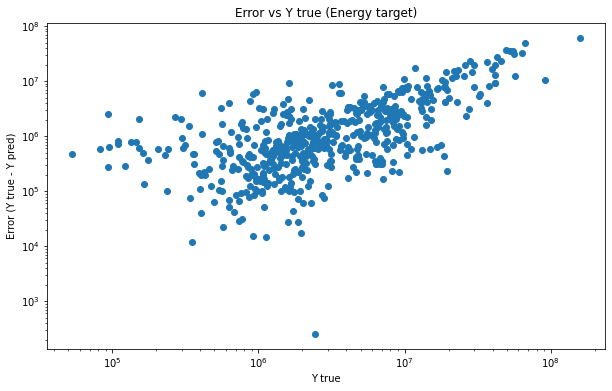

In [19]:
X = np.expm1(Y_energy_test)
Y = abs(np.expm1(Y_energy_test) - np.expm1(gb_energy.predict(X_test)))
plt.figure(figsize=(10,6))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Y true")
plt.ylabel("Error (Y true - Y pred)")
plt.title("Error vs Y true (Energy target)")
plt.scatter(X,Y);

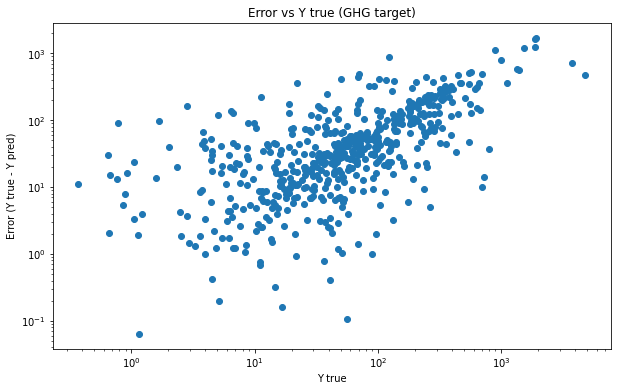

In [20]:
X = np.expm1(Y_ghg_test)
Y = abs(np.expm1(Y_ghg_test) - np.expm1(gb_ghg.predict(X_test)))
plt.figure(figsize=(10,6))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Y true")
plt.ylabel("Error (Y true - Y pred)")
plt.title("Error vs Y true (GHG target)")
plt.scatter(X,Y);

In [22]:
type_train, type_test= train_test_split(df['PrimaryPropertyType'], test_size=0.3, stratify = df['PrimaryPropertyType'], random_state = 1)

In [23]:
Y_energy = abs(np.expm1(Y_energy_test) - np.expm1(gb_energy.predict(X_test)))
data_energy = pd.DataFrame(data = {'Type': type_test, 'abs error' : Y_energy, 'relative error': Y/np.expm1(Y_energy_test)})
data_energy = data_energy.groupby(by='Type').median()
Y_ghg = abs(np.expm1(Y_ghg_test) - np.expm1(gb_ghg.predict(X_test)))
data_ghg = pd.DataFrame(data = {'Type': type_test, 'abs error' : Y_ghg, 'relative error': Y/np.expm1(Y_ghg_test)})
data_ghg = data_ghg.groupby(by='Type').median()

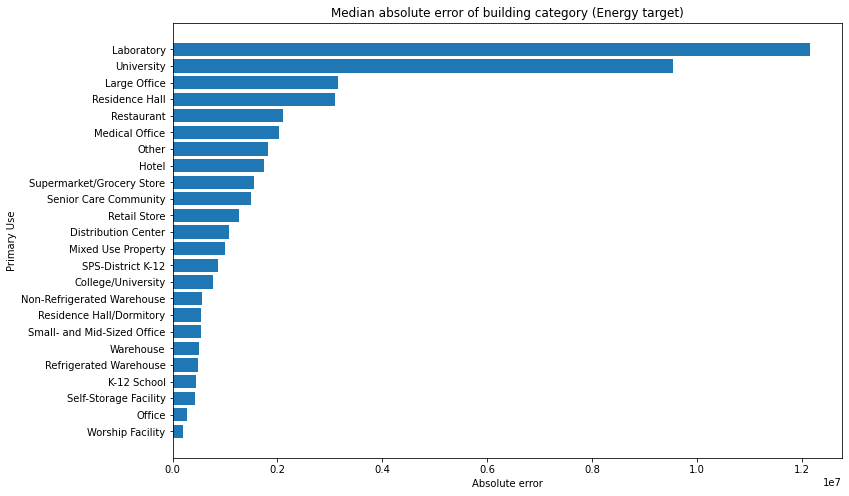

In [25]:
data1 = data_energy.sort_values(by='abs error')
plt.figure(figsize=(12,8))
plt.xlabel("Absolute error")
plt.ylabel("Primary Use")
plt.title("Median absolute error of building category (Energy target)")
plt.barh(data1.index , data1['abs error']);

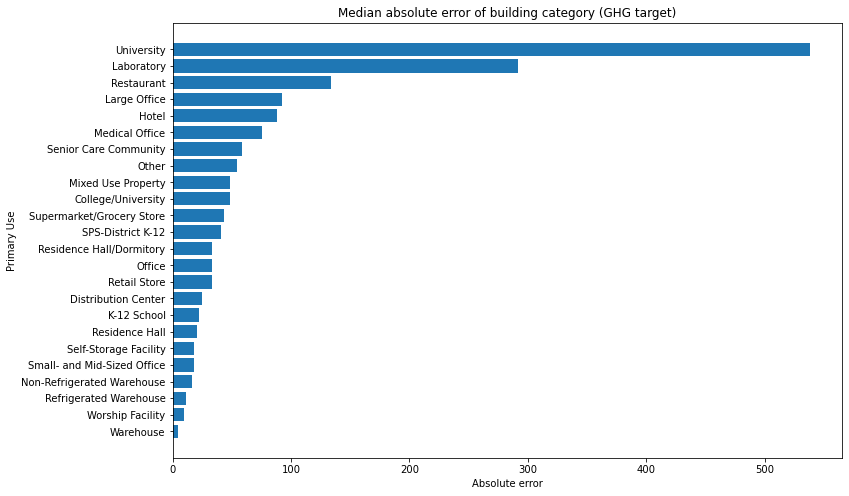

In [26]:
data2 = data_ghg.sort_values(by='abs error')
plt.figure(figsize=(12,8))
plt.xlabel("Absolute error")
plt.ylabel("Primary Use")
plt.title("Median absolute error of building category (GHG target)")
plt.barh(data2.index , data2['abs error']);

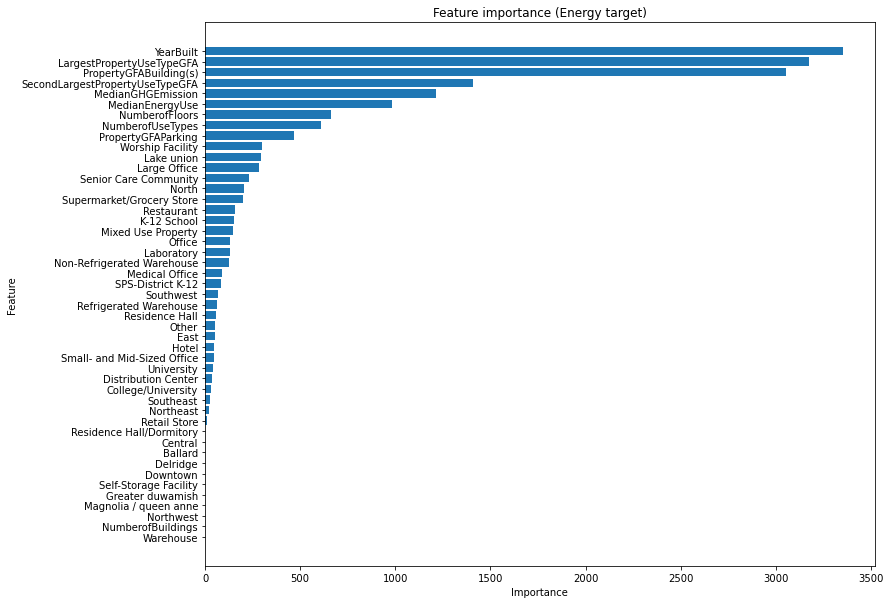

In [516]:
names = sorted(df['PrimaryPropertyType'].unique())+sorted(df['Neighborhood'].unique())+X_quant.columns.tolist()
data = pd.DataFrame(data = {'Names' : names, 'Importance':gb_energy.feature_importances_}).sort_values(by='Importance')
plt.figure(figsize=(12,10))
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature importance (Energy target)")
plt.barh(data['Names'] ,data['Importance']);

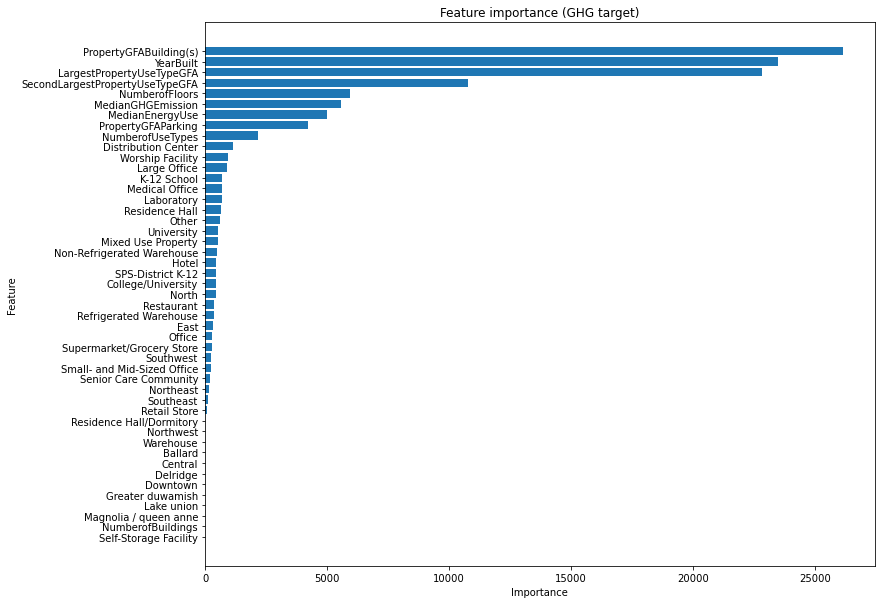

In [517]:
names = sorted(df['PrimaryPropertyType'].unique())+sorted(df['Neighborhood'].unique())+X_quant.columns.tolist()
data = pd.DataFrame(data = {'Names' : names, 'Importance':gb_ghg.feature_importances_}).sort_values(by='Importance')
plt.figure(figsize=(12,10))
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature importance (GHG target)")
plt.barh(data['Names'] ,data['Importance']);

Sélection des features les plus importantes 

In [14]:
skb=SelectKBest(f_regression, k=15)
skb.fit(X_train,Y_energy_train)
X_new_train = skb.transform(X_train)
X_new_test = skb.transform(X_test)

In [15]:
gb_energy_new = LGBMRegressor(n_estimators = 2200, max_depth = 4, learning_rate = 0.01, boosting_type = 'gbdt');
gb_energy_new.fit(X_new_train,Y_energy_train)
start_time=time.time()
print(round(metrics.r2_score(np.expm1(Y_energy_test),np.expm1(gb_energy_new.predict(X_new_test))),5))
print(round(metrics.mean_squared_error(np.expm1(Y_energy_test),np.expm1(gb_energy_new.predict(X_new_test)), squared = False),5))
print(time.time()-start_time)

0.73973
6142758.70332
0.062170982360839844


In [38]:
skb_ghg=SelectKBest(f_regression, k=45)
skb_ghg.fit(X_train,Y_ghg_train)
X_new_ghg_train = skb_ghg.transform(X_train)
X_new_ghg_test = skb_ghg.transform(X_test)

In [39]:
gb_ghg_new = LGBMRegressor(n_estimators = 2180, max_depth = 4, learning_rate = 0.2, boosting_type = 'goss');
gb_ghg_new.fit(X_new_ghg_train,Y_ghg_train)
start_time=time.time()
print(round(metrics.r2_score(np.expm1(Y_ghg_test),np.expm1(gb_ghg_new.predict(X_new_ghg_test))),5))
print(round(metrics.mean_squared_error(np.expm1(Y_ghg_test),np.expm1(gb_ghg_new.predict(X_new_ghg_test)), squared = False),5))
print(time.time()-start_time)

0.60931
212.01461
0.07018733024597168


In [ ]:
estimator = LGBMRegressor(n_estimators = 2200, max_depth = 4, learning_rate = 0.01, boosting_type = 'gbdt');
rfe_gs=GridSearchCV(RFE(estimator), param_grid = {'n_features_to_select':range(5,40,2)})
rfe_gs.fit(X_train,Y_energy_train)
X_rfe_train = rfe.transform(X_train)
X_rfe_test = skb.transform(X_test)

In [529]:
rfe_gs.best_estimator_

RFE(estimator=LGBMRegressor(learning_rate=0.01, max_depth=4, n_estimators=2200),
    n_features_to_select=21)

In [532]:
start_time=time.time()
print(round(metrics.r2_score(np.expm1(Y_energy_test),np.expm1(rfe_gs.predict(X_test))),5))
print(time.time()-start_time)

0.73808
0.051004886627197266


In [527]:
X_rfe_train.shape

(1260, 20)

## Impact de la variable ENERGYSTARScore

In [410]:
#Sélection du dataset sans l'ENERGYSTARScore pour comparaison sur le même échantillon
df_ESS=df.dropna(subset=['ENERGYSTARScore'])

In [411]:
X_quant_w_ESS = df_ESS[['YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','MedianEnergyUse','MedianGHGEmission','NumberofUseTypes','ENERGYSTARScore']]
X_quant_w_ESS.values.shape

(1211, 11)

In [412]:
X_quant_wo_ESS = df_ESS[['YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','MedianEnergyUse','MedianGHGEmission','NumberofUseTypes']]
X_quant_wo_ESS.values.shape

(1211, 10)

In [413]:
data=df_ESS['Neighborhood'].values.reshape(-1,1)
enc = preprocessing.OneHotEncoder()
neighborhood_enc_ESS = enc.fit_transform(data).toarray()
neighborhood_enc_ESS.shape

(1211, 13)

In [414]:
data=df_ESS['PrimaryPropertyType'].values.reshape(-1,1)
enc = preprocessing.OneHotEncoder()
PropertyType_enc_ESS = enc.fit_transform(data).toarray()
PropertyType_enc_ESS.shape

(1211, 20)

In [415]:
# Concatenation des 2 encodages
X_cat_ESS = np.concatenate((neighborhood_enc_ESS,PropertyType_enc_ESS),axis=1)
X_cat_ESS.shape

(1211, 33)

In [416]:
Y_energy_ESS = df_ESS['SiteEnergyUse(kBtu)_log']
Y_ghg_ESS = df_ESS['GHGEmissions(MetricTonsCO2e)_log']

In [417]:
X_cat_ESS_train, X_cat_ESS_test, X_quant_w_ESS_train, X_quant_w_ESS_test, X_quant_wo_ESS_train, X_quant_wo_ESS_test, Y_energy_ESS_train, Y_energy_ESS_test, Y_ghg_ESS_train, Y_ghg_ESS_test = train_test_split(X_cat_ESS, X_quant_w_ESS, X_quant_wo_ESS, Y_energy_ESS, Y_ghg_ESS, test_size=0.3, random_state = 6)

In [418]:
# On standardise les variables input quantitatives. On fit_transform sur le jeu d'entrainement et on transforme le jeu de test
std = preprocessing.StandardScaler()
X_quant_w_ESS_train_scaled = std.fit_transform(X_quant_w_ESS_train)
X_quant_w_ESS_test_scaled = std.transform(X_quant_w_ESS_test)
X_quant_wo_ESS_train_scaled = std.fit_transform(X_quant_wo_ESS_train)
X_quant_wo_ESS_test_scaled = std.transform(X_quant_wo_ESS_test)

In [419]:
# Concatenation pour définir les input
X_train_w_ESS = np.concatenate((X_cat_ESS_train,X_quant_w_ESS_train_scaled),axis=1)
X_test_w_ESS = np.concatenate((X_cat_ESS_test,X_quant_w_ESS_test_scaled),axis=1)
X_train_wo_ESS = np.concatenate((X_cat_ESS_train,X_quant_wo_ESS_train_scaled),axis=1)
X_test_wo_ESS = np.concatenate((X_cat_ESS_test,X_quant_wo_ESS_test_scaled),axis=1)

In [639]:
gb_energy_w_ESS = LGBMRegressor()
gb_energy_w_ESS_gs = GridSearchCV(estimator = gb_energy_w_ESS, param_grid={'n_estimators':[100],'max_depth':[2,3,4],'learning_rate':[0.0001,0.001,0.01,0.1,1]}, cv=5)
gb_energy_w_ESS_gs.fit(X_train_w_ESS, Y_energy_ESS_train)
print(round(metrics.r2_score(np.expm1(Y_energy_ESS_test),np.expm1(gb_energy_w_ESS_gs.predict(X_test_w_ESS))),5))
print(round(metrics.mean_squared_error(np.expm1(Y_energy_ESS_test),np.expm1(gb_energy_w_ESS_gs.predict(X_test_w_ESS)), squared = False),5))

0.62896
5592453.15411


In [640]:
gb_energy_wo_ESS = LGBMRegressor()
gb_energy_wo_ESS_gs = GridSearchCV(estimator = gb_energy_wo_ESS, param_grid={'n_estimators':[100],'max_depth':[2,3,4],'learning_rate':[0.0001,0.001,0.01,0.1,1]}, cv=5)
gb_energy_wo_ESS_gs.fit(X_train_wo_ESS, Y_energy_ESS_train)
print(round(metrics.r2_score(np.expm1(Y_energy_ESS_test),np.expm1(gb_energy_wo_ESS_gs.predict(X_test_wo_ESS))),5))
print(round(metrics.mean_squared_error(np.expm1(Y_energy_ESS_test),np.expm1(gb_energy_wo_ESS_gs.predict(X_test_wo_ESS)), squared = False),5))

0.63143
5573794.45471


In [643]:
gb_ghg_w_ESS = LGBMRegressor()
gb_ghg_w_ESS_gs = GridSearchCV(estimator = gb_ghg_w_ESS, param_grid={'n_estimators':[100],'max_depth':[2,3,4],'learning_rate':[0.0001,0.001,0.01,0.1,1]}, cv=5)
gb_ghg_w_ESS_gs.fit(X_train_w_ESS, Y_ghg_ESS_train)
print(round(metrics.r2_score(np.expm1(Y_ghg_ESS_test),np.expm1(gb_ghg_w_ESS_gs.predict(X_test_w_ESS))),5))
print(round(metrics.mean_squared_error(np.expm1(Y_ghg_ESS_test),np.expm1(gb_ghg_w_ESS_gs.predict(X_test_w_ESS)), squared = False),5))

0.43282
104.40575


In [642]:
gb_ghg_wo_ESS = LGBMRegressor()
gb_ghg_wo_ESS_gs = GridSearchCV(estimator = gb_ghg_wo_ESS, param_grid={'n_estimators':[100],'max_depth':[2,3,4],'learning_rate':[0.0001,0.001,0.01,0.1,1]}, cv=5)
gb_ghg_wo_ESS_gs.fit(X_train_wo_ESS, Y_ghg_ESS_train)
print(round(metrics.r2_score(np.expm1(Y_ghg_ESS_test),np.expm1(gb_ghg_wo_ESS_gs.predict(X_test_wo_ESS))),5))
print(round(metrics.mean_squared_error(np.expm1(Y_ghg_ESS_test),np.expm1(gb_ghg_wo_ESS_gs.predict(X_test_wo_ESS)), squared = False),5))

0.52295
95.75094
